# Star Trail: Center Finder 2

Code based on: 
- Astride: https://github.com/dwkim78/ASTRiDE#4-how-to-use-astride
- Circle-Fit: https://pypi.org/project/circle-fit/

In [1]:
from __future__ import print_function, unicode_literals, absolute_import, division
import sys
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
%config InlineBackend.figure_format = 'retina'

In [2]:
from helper import read_image, display

In [3]:
# !pip install git+https://github.com/dwkim78/ASTRiDE

In [4]:
# !pip install circle-fit

## Load Image

In [5]:
# Load Image
code = 102
fname = 'coadds/GenericCamera%i-20230309-images1352-1512-coadd.fits'%code
img = read_image(fname)

## Star Trail Arcs Selection

I choose the biggest arcs. The selection is perfomed by taking the largest perimeters.

In [6]:
# Import the ASTRiDE library.
from astride import Streak

# Read a fits image and create a Streak instance.
streak = Streak(fname, contour_threshold=1.5, area_cut=25, radius_dev_cut=0.5,remove_bkg='map', output_path='./')

# streak.raw_image = img

# Detect streaks.
streak.detect()

In [7]:
df = pd.DataFrame(streak.streaks)
df = df.sort_values(by='perimeter', ascending=False)

In [8]:
# only the 100 first largest arcs
selection = df.index.to_numpy()[:]
df[:5]

index                                                  x  \
285    286  [2337.0, 2336.0, 2335.0, 2334.0, 2333.53390359...   
56      57  [17.0, 16.0, 15.833741531893377, 16.0, 17.0, 1...   
352    353  [498.0, 497.0, 496.0, 495.0, 494.0, 493.850349...   
139    140  [371.0, 370.0, 369.8427740743233, 370.0, 370.1...   
244    245  [327.0, 326.0, 325.0, 324.33999600037913, 324....   

                                                     y     x_center  \
285  [1642.8797081242685, 1642.599614159063, 1642.4...  2467.589575   
56   [687.7521020013817, 687.1667239728129, 687.0, ...    73.838338   
352  [2079.1406600892046, 2079.05708750044, 2079.57...   379.741507   
139  [1067.2260831911951, 1067.2344992731244, 1067....   380.193275   
244  [1577.2602010628286, 1577.2300440162815, 1577....   265.829348   

        y_center    perimeter         area  shape_factor  radius_deviation  \
285  1518.023680  2236.772643  5324.782525      0.013374          0.696175   
56    411.744301  1840.583365  7442.916413      0.027608          0.556939   
352  1908.807236  1771.530774  4672.650392      0.018710          0.648873   
139   826.745763  1411.696866  3535.684503      0.022295          0.558955   
244  1366.069998  1284.346656  3768.273190      0.028707          0.555214   

        slope    intercept  connectivity        x_min        x_max  \
285 -1.004965  3993.670447            -1  2328.200620  2574.316613   
56  -3.547894   677.449611            -1    15.716981   145.080166   
352  1.614068  1295.791045            -1   241.532500   504.318747   
139 -8.280190  3989.364144            -1   361.884706   416.100866   
244  4.077957   282.662288            -1   222.865002   327.825993   

           y_min        y_max  box_plotted  slope_angle  
285  1396.420886  1642.879708        False   -45.141890  
56    218.727003   687.752102        False   -74.259121  
352  1658.865346  2079.572032        False    58.219608  
139   608.797377  1067.234499        False   -83.113729  
244  1167.900742  1577.824853        False    76.221763

# Fit A Circle

In [16]:
results = {}

def print_results(tag):
    print('Selection: %s'%tag)
    print('xc, yc: %i, %i'%(results[tag][0],results[tag][1]))

## Initial Fit

Fit all arcs without any selection.

In [10]:
edges = streak.streaks

In [17]:
from circle_fit import prattSVD, taubinSVD, plot_data_circle
out = np.empty((len(edges),4), dtype=float)

x = np.empty((0,),dtype=float)
y = np.empty((0,),dtype=float)
c = np.empty((0,),dtype=int)

for ix in range(len(edges)):
    xi, yi = edges[ix]['x'].astype(int), edges[ix]['y'].astype(int)
    points = np.vstack([xi, yi]).T
    xc, yc, r, sigma = taubinSVD(points)
    out[ix] = np.array([xc, yc, r, sigma])
    
    x = np.append(x, xi)
    y = np.append(y, yi)
    c = np.append(c, ix*np.ones_like(xi))

In [18]:
# mean solution
xc_mean, yc_mean, r0m, sigma = np.nanmedian(out, axis=0)
R0 = np.hypot(x-xc_mean, y-yc_mean)

results['all'] = xc_mean, yc_mean

print_results('all')

Selection: all
xc, yc: 1788, 1044


## Select Inner Trails

In [21]:
perimeter = np.array([edge['perimeter'] for edge in edges])
for i in range(3):
    R0 = np.hypot(x-xc_mean, y-yc_mean)
    _, ixs = np.unique(c, return_index=True)

    outer = (R0[ixs]>1000) & (perimeter>500)
    inner = R0[ixs]<500
    # bad = (np.abs(out[:,0]-xc_mean)>100)|(np.abs(out[:,1]-yc_mean)>100)
    xco, yco, r0m, sigma = np.nanmedian(out[outer,:], axis=0)
    xci, yci, r0m, sigma = np.nanmedian(out[inner,:], axis=0)
    
    xc_mean, yc_mean = xci, yci

In [24]:
results['outer trails'] = xco, yco
results['inner trails'] = xci, yci

print_results('outer trails')
print_results('inner trails')

Selection: outer trails
xc, yc: 1791, 975
Selection: inner trails
xc, yc: 1913, 950


In [27]:
# angular size
R0 = np.hypot(x-xci, y-yci)

# compute angular size
angSize = np.zeros(len(edges))
# for ix in [ 35,  44, 112, 128, 190, 199]:
for ix in range(len(edges)):
    xi, yi = edges[ix]['x'].astype(int), edges[ix]['y'].astype(int)
    thetai = np.abs(np.arctan((yi-yci)/(xi-xci))*(180/np.pi)) # deg
    ang_length = np.max(thetai)-np.min(thetai)
    angSize[ix] = ang_length


Text(0.5, 1.0, 'Arcs Distrtibution')

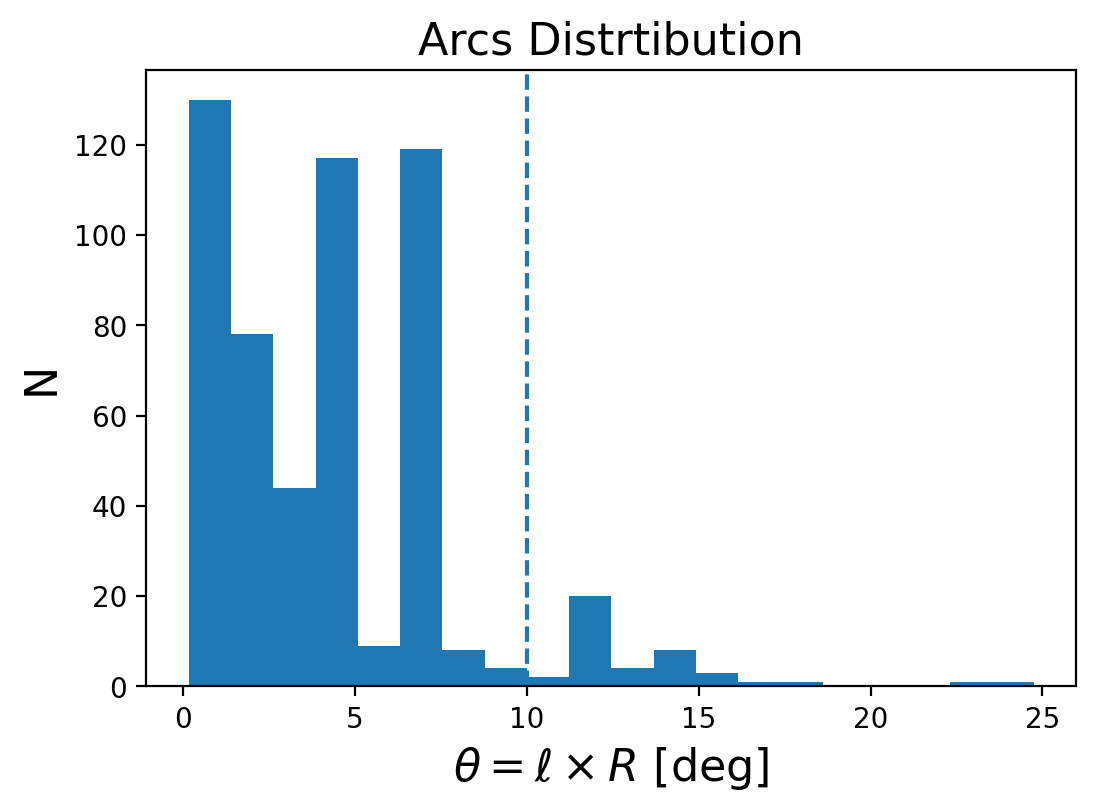

In [66]:
plt.figure(figsize=(6,4))
_ = plt.hist(angSize, bins=20)
plt.axvline(10.,ls='--')
plt.xlabel(r'$\theta = \ell \times R$ [deg]',fontsize=16)
plt.ylabel('N',fontsize=16)
plt.title('Arcs Distrtibution',fontsize=16)

## Arcs Selection

In [42]:
arc_selection = np.where(angSize>10.)[0]

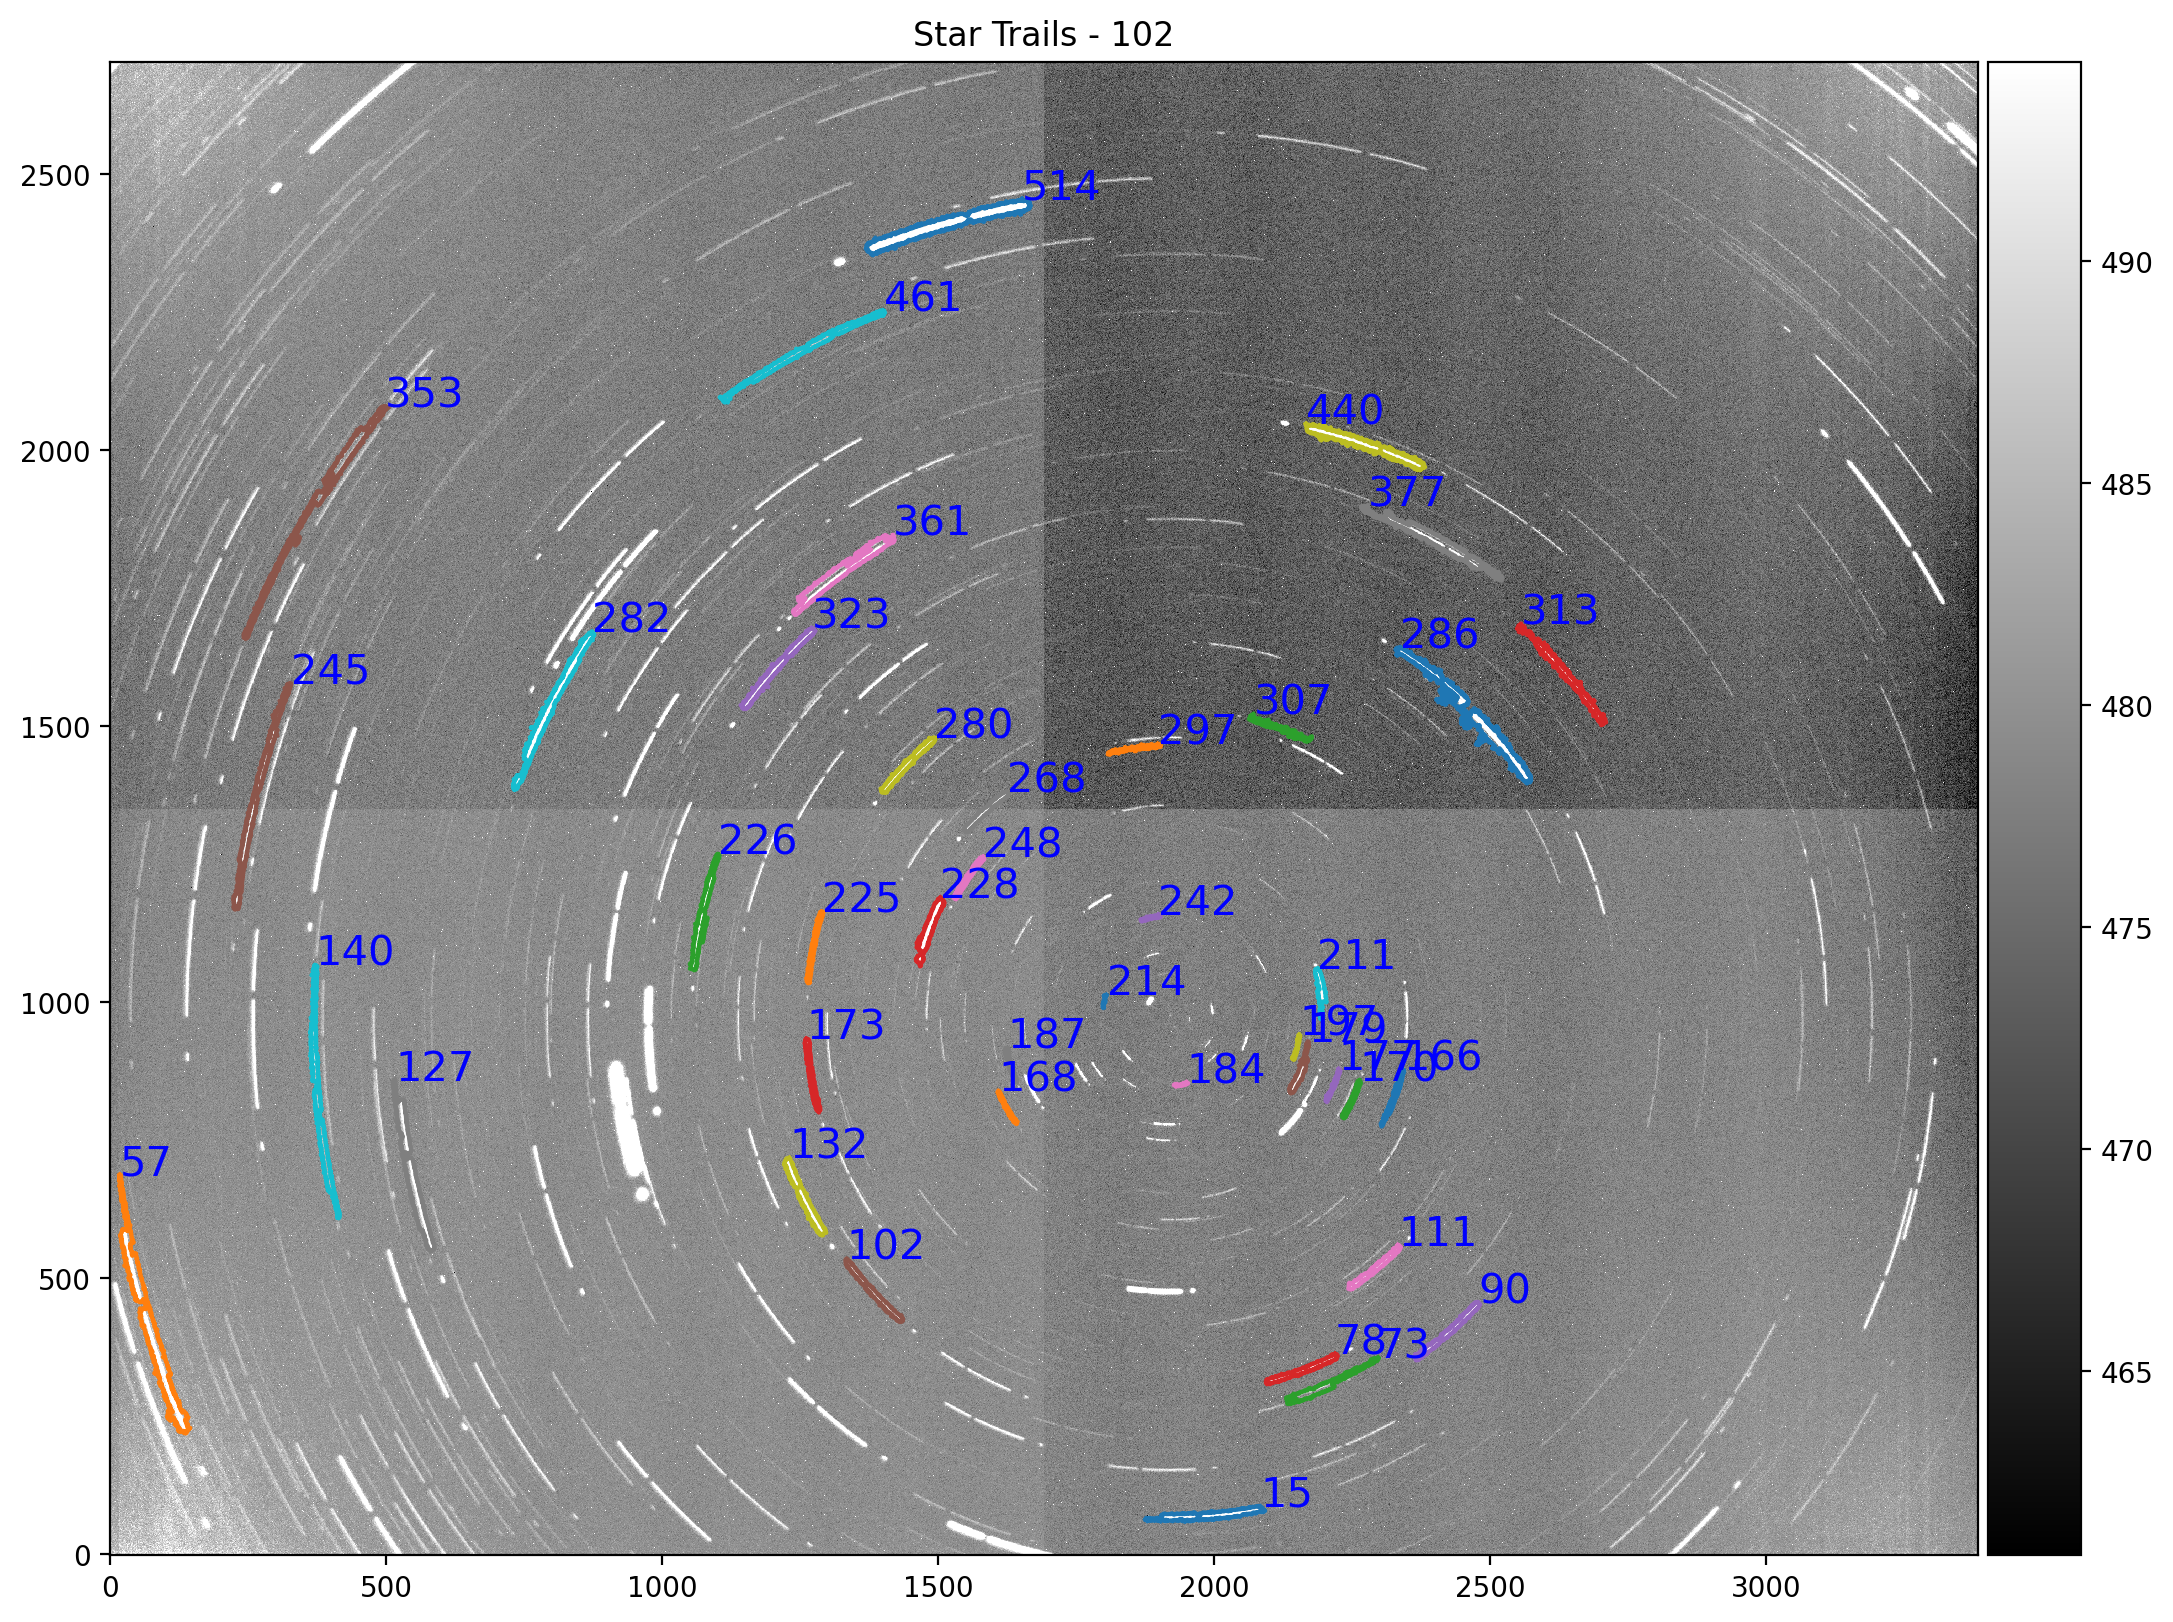

In [43]:
fig, (ax1) = plt.subplots(1,1, figsize=(12,8), sharex='all', sharey='all')

# Plot all contours.
for n in arc_selection:
    edge = edges[n]
    ax1.plot(edge['x'], edge['y'],mfc='o',mec='r',ms=5)
    ax1.text(edge['x'][0], edge['y'][1],
            '%d' % (edge['index']), color='b', fontsize=15)

display(img, ax=ax1, fig=fig)
fig.tight_layout()
ax1.set_title('Star Trails - %i'%code)
fig.savefig('star_trail_centroid_trails_%i.png'%code, dpi=120)
# plt.plot(df.x_center, df.y_center, 'ro')

In [44]:
# mean solution
xc_mean, yc_mean, r0m, sigma = np.nanmedian(out[arc_selection,:], axis=0)
R0 = np.hypot(x-xc_mean, y-yc_mean)

results['angular size'] = xc_mean, yc_mean

print_results('angular size')

Selection: angular size
xc, yc: 1916, 957


In [45]:
c[np.isin(c, arc_selection)]

array([ 14,  14,  14, ..., 513, 513, 513])

In [46]:
# angSize

## Visualize the Results

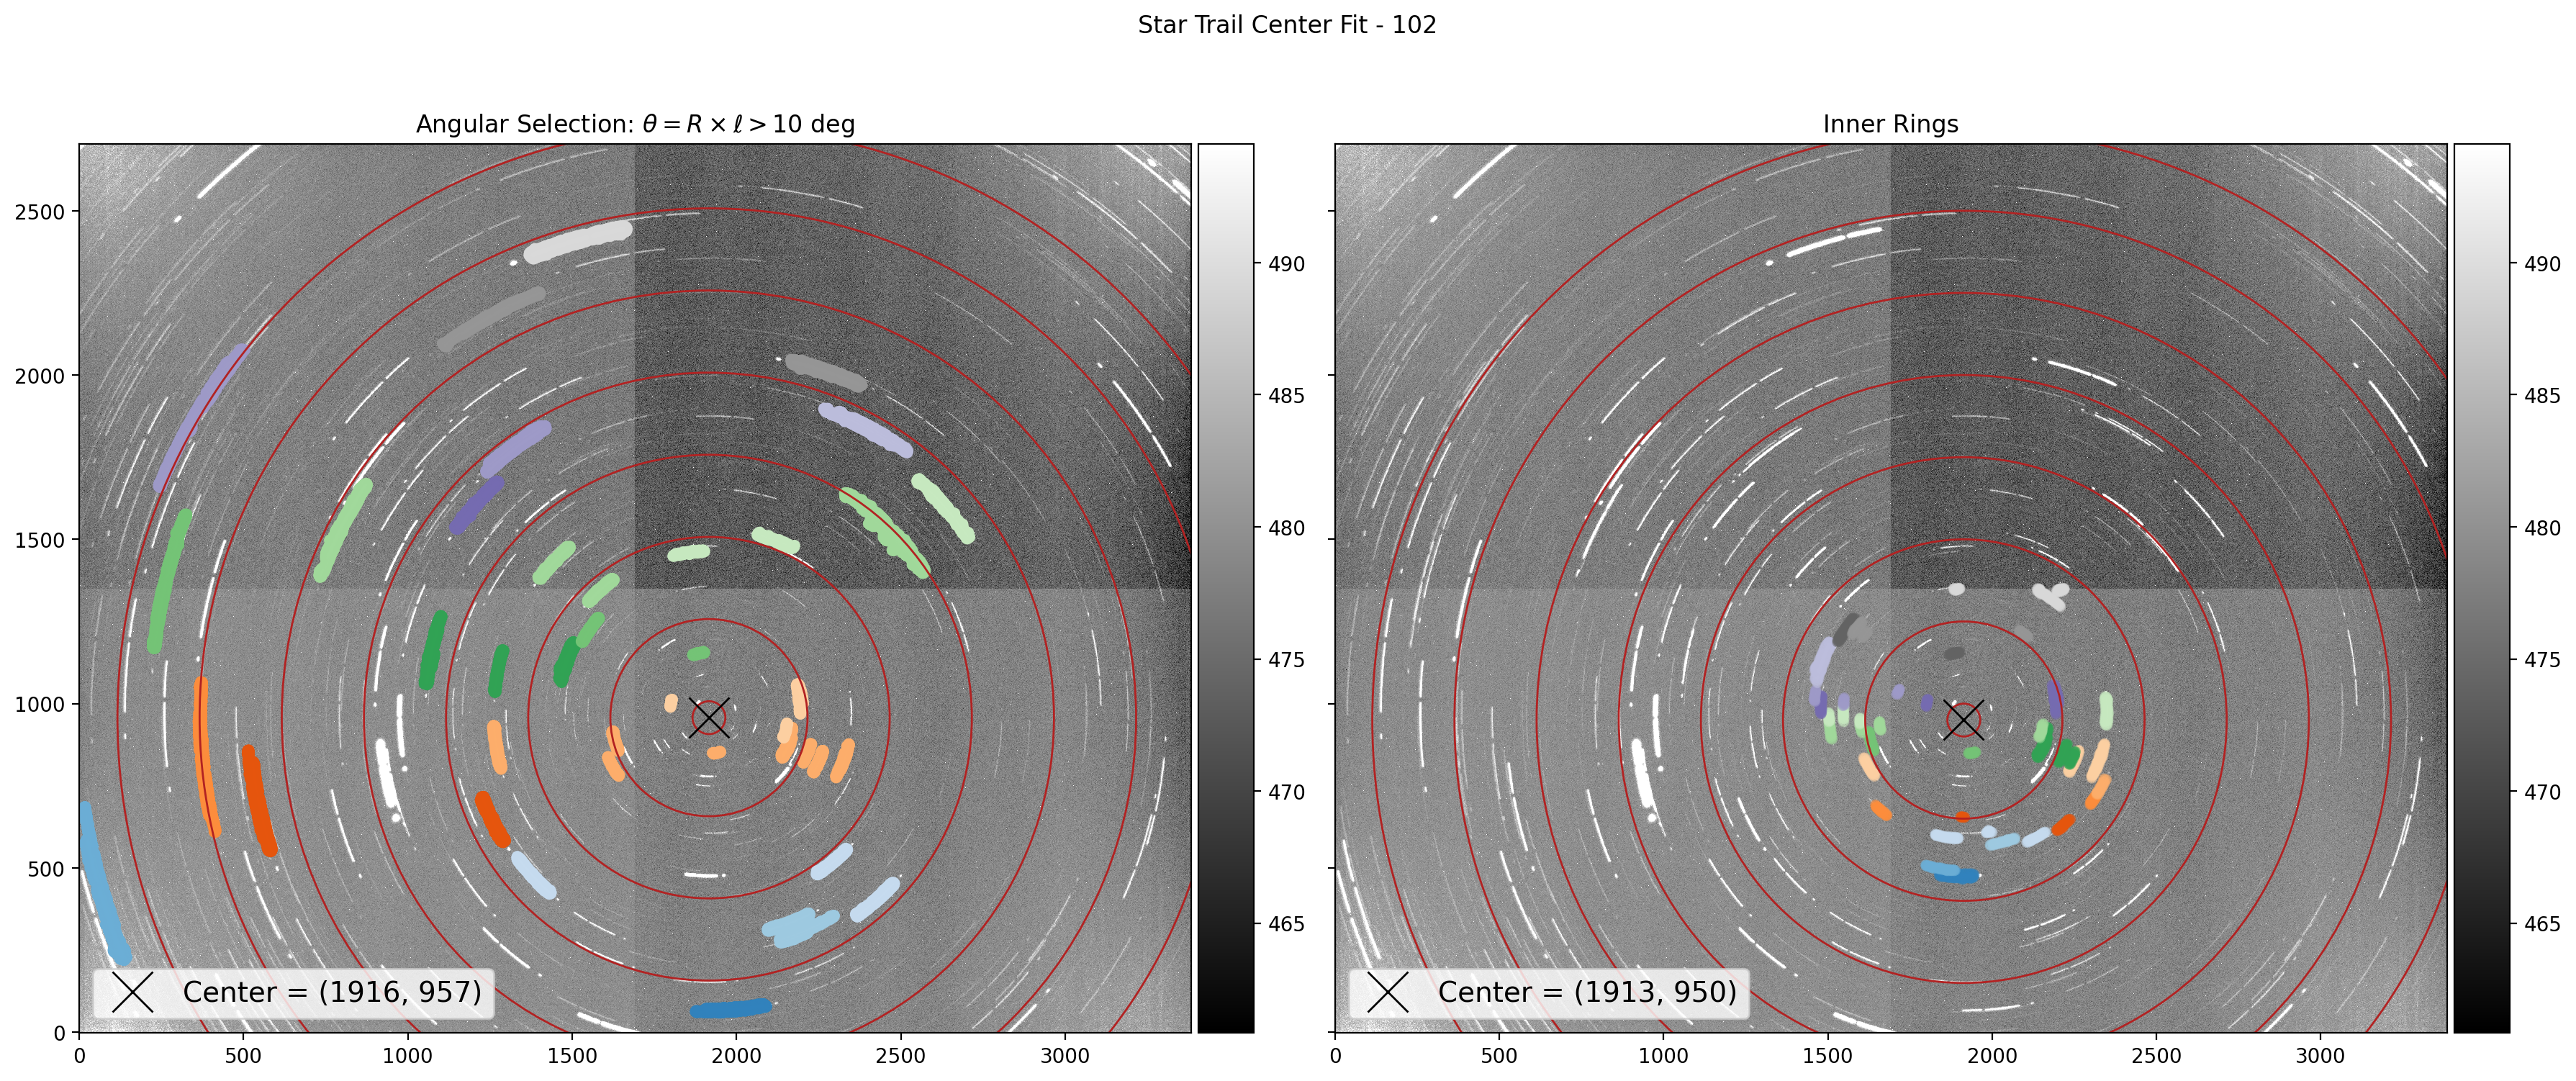

In [65]:
from matplotlib.patches import Circle
fig, (ax1, ax2) = plt.subplots(1,2, figsize=(18,8), sharex='all', sharey='all')

arc_mask = np.where(np.isin(c, arc_selection))[0]

ax1.plot(xc_mean,yc_mean,'rx',mfc='none',mec='k',ms=20,label='Center = (%i, %i)'%(xc_mean,yc_mean))
ax1.scatter(x[arc_mask], y[arc_mask], c=c[arc_mask], s=20, cmap='tab20c', alpha=0.5)
ax1.legend(loc=3, fontsize=14)

for _ in np.arange(50, 2000, 250):
    ax1.add_patch(Circle((xc_mean,yc_mean), _, color='firebrick', ls='-', fc='none'))
    
ax1.set_title(r'Angular Selection: $\theta = R \times \ell > 10$ deg')
display(img,ax=ax1, fig=fig)

inner = R0 < 500

ax2.plot(xci,yci,'rx',mfc='none',mec='k',ms=20,label='Center = (%i, %i)'%(xci,yci))
ax2.scatter(x[inner][::10], y[inner][::10], c=c[inner][::10], s=20, cmap='tab20c', alpha=0.5)

ax2.legend(loc=3, fontsize=14)
for _ in np.arange(50, 2000, 250):
    ax2.add_patch(Circle((xci,yci), _, color='firebrick', ls='-', fc='none'))

ax2.set_title('Inner Rings')
display(img,ax=ax2, fig=fig)

fig.suptitle('Star Trail Center Fit - %i'%code)
fig.tight_layout()
fig.savefig('star_trail_centroid_%i.png'%code, dpi=120)